In [1]:
import os
import numpy as np
import rasterio
from sklearn.model_selection import train_test_split
from rasterio.plot import show
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Directories
non_forest_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\non_forest"
forest_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\forest"

In [3]:
# Load all non-forest and forest files
def load_tif_files(directory):
    """
    Load and return a list of arrays representing TIFF files from a directory.
    Each array will have a shape of (3, h, w) corresponding to the bands.
    """
    tif_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.tif')]
    bands_list = []
    
    for file_path in tif_files:
        with rasterio.open(file_path) as src:
            bands = src.read()  # shape (3, h, w)
            bands_list.append(bands)
    
    return tif_files, bands_list

non_forest_files, non_forest_data = load_tif_files(non_forest_dir)
forest_files, forest_data = load_tif_files(forest_dir)

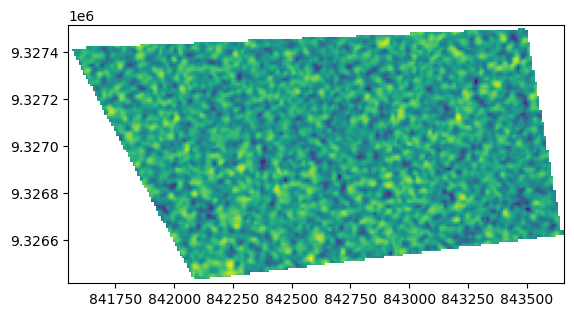

Non-Forest Image Resolution: (10.0, 10.0) meters per pixel


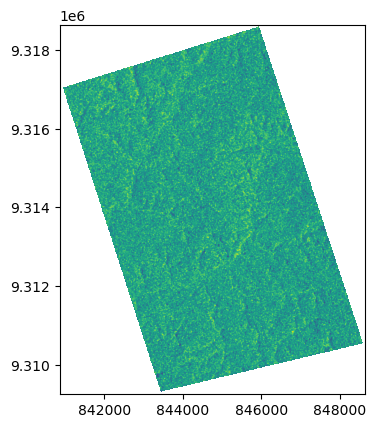

Forest Image Resolution: (10.0, 10.0) meters per pixel


In [4]:
# Function to calculate image resolution
def calculate_resolution(file_path):
    with rasterio.open(file_path) as src:
        transform = src.transform
        # Calculate pixel size (resolution)
        pixel_size_x = transform[0]  # Pixel width in meters
        pixel_size_y = abs(transform[4])  # Pixel height in meters
    return pixel_size_x, pixel_size_y

# Display one example image from each class
def display_example_image(file_path, title):
    with rasterio.open(file_path) as image_data:
        show(image_data)
        print(f"{title} Image Resolution: {calculate_resolution(file_path)} meters per pixel")

display_example_image(non_forest_files[0], "Non-Forest")
display_example_image(forest_files[0], "Forest")

In [5]:
# Function to extract statistical features from a tile
def extract_features_from_tile(tile):
    """
    Extract statistical features from a tile.
    """
    tile_features = []
    for band in range(tile.shape[0]):
        band_data = tile[band]
        tile_features.extend([
            band_data.mean(),  # Mean
            band_data.std(),   # Standard deviation
            band_data.min(),   # Min value
            band_data.max(),   # Max value
            np.median(band_data)  # Median
        ])
    return tile_features

# Function to divide an image into tiles and compute features
def tile_image(image_data, tile_size=16):
    """
    Divide an image into tiles, filtering out any tiles that contain NaN values,
    and compute statistical features for each valid tile.
    """
    h, w = image_data.shape[1], image_data.shape[2]
    tiles = []

    for i in range(0, h, tile_size):
        for j in range(0, w, tile_size):
            tile = image_data[:, i:i+tile_size, j:j+tile_size]
            if tile.shape[1] == tile_size and tile.shape[2] == tile_size:
                if not np.isnan(tile).any():  # Ensure the tile has no NaN values
                    tile_features = extract_features_from_tile(tile)
                    tiles.append(tile_features)
    
    return np.array(tiles)

# Apply tiling and feature extraction to all non-forest and forest images
def extract_all_tiles(data, tile_size=8):
    return np.vstack([tile_image(bands, tile_size=tile_size) for bands in data])

Training set size: 221711 samples
Validation set size: 47509 samples
Test set size: 47510 samples


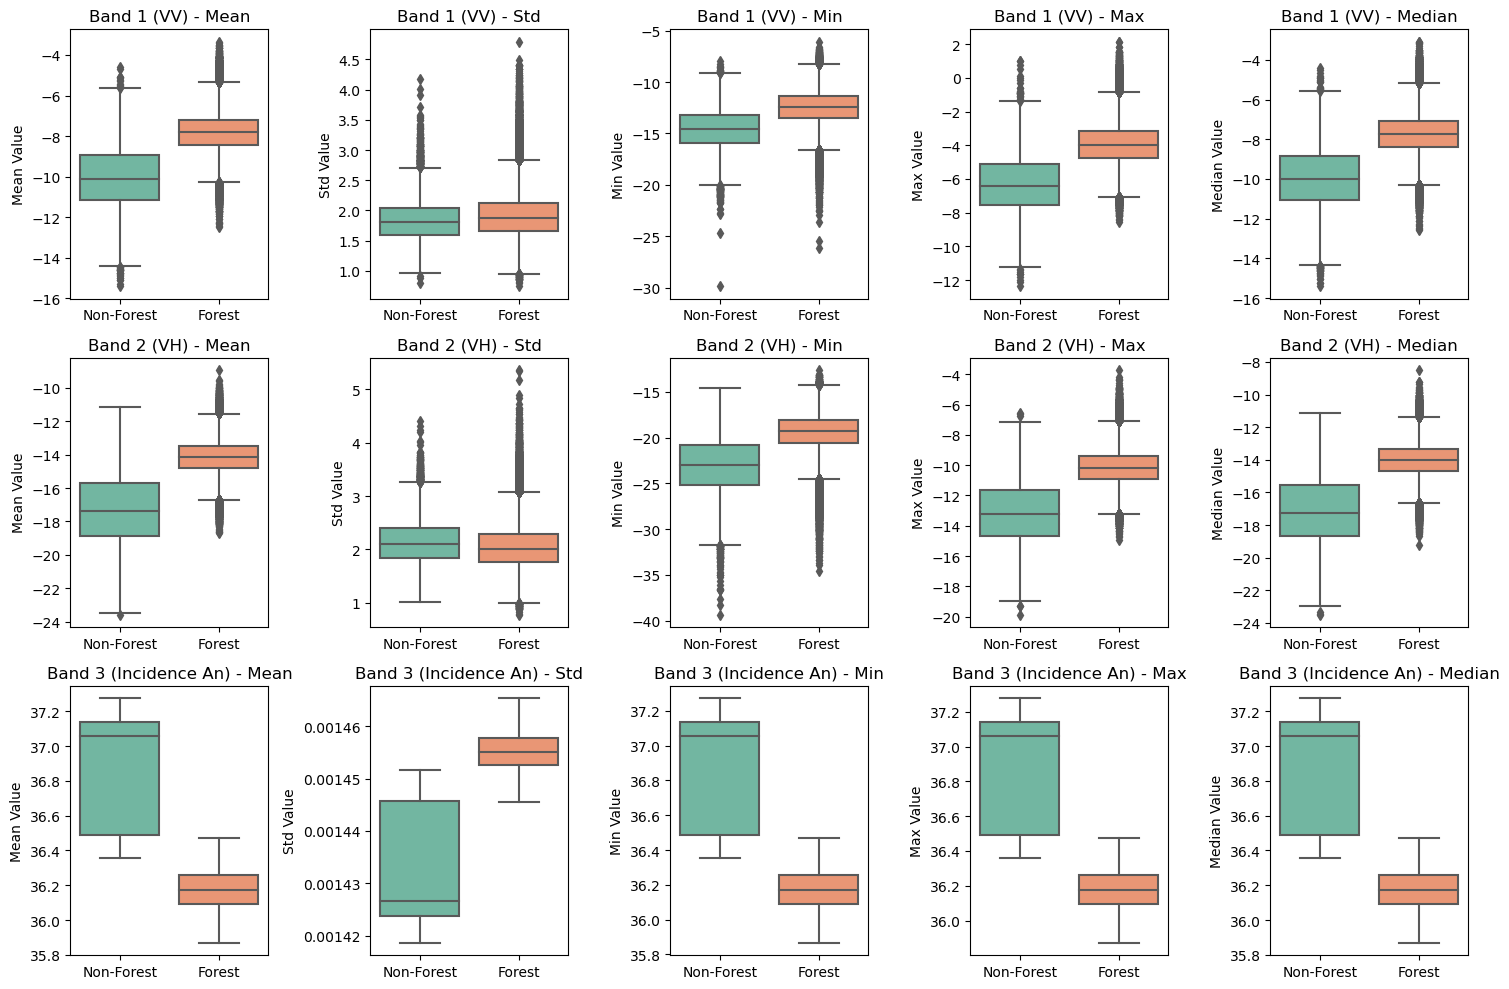

In [17]:
selected_tile_size = 8
non_forest_tiles_16 = extract_all_tiles(non_forest_data, tile_size=selected_tile_size)
forest_tiles_16 = extract_all_tiles(forest_data, tile_size=selected_tile_size)

# Combine and label tiles
X = np.vstack([non_forest_tiles_16, forest_tiles_16])
y = np.hstack([np.zeros(non_forest_tiles_16.shape[0]), np.ones(forest_tiles_16.shape[0])])

# Split the data: 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Visualize statistical features
def visualize_features(X, y, title_prefix=""):
    non_forest_features = X[y == 0]
    forest_features = X[y == 1]

    feature_names = ['Mean', 'Std', 'Min', 'Max', 'Median']
    bands = ['Band 1 (VV)', 'Band 2 (VH)', 'Band 3 (Incidence An)']
    n_features_per_band = 5

    plt.figure(figsize=(15, 10))

    for band_index, band in enumerate(bands):
        for feature_index, feature_name in enumerate(feature_names):
            feature_idx = band_index * n_features_per_band + feature_index

            plt.subplot(len(bands), n_features_per_band, feature_idx + 1)
            sns.boxplot(data=[non_forest_features[:, feature_idx], forest_features[:, feature_idx]], palette="Set2")

            plt.title(f'{band} - {feature_name}')
            plt.xticks([0, 1], ['Non-Forest', 'Forest'])
            plt.ylabel(f'{feature_name} Value')

    plt.tight_layout()
    plt.show()

visualize_features(X_train, y_train, title_prefix="Training Set: ")

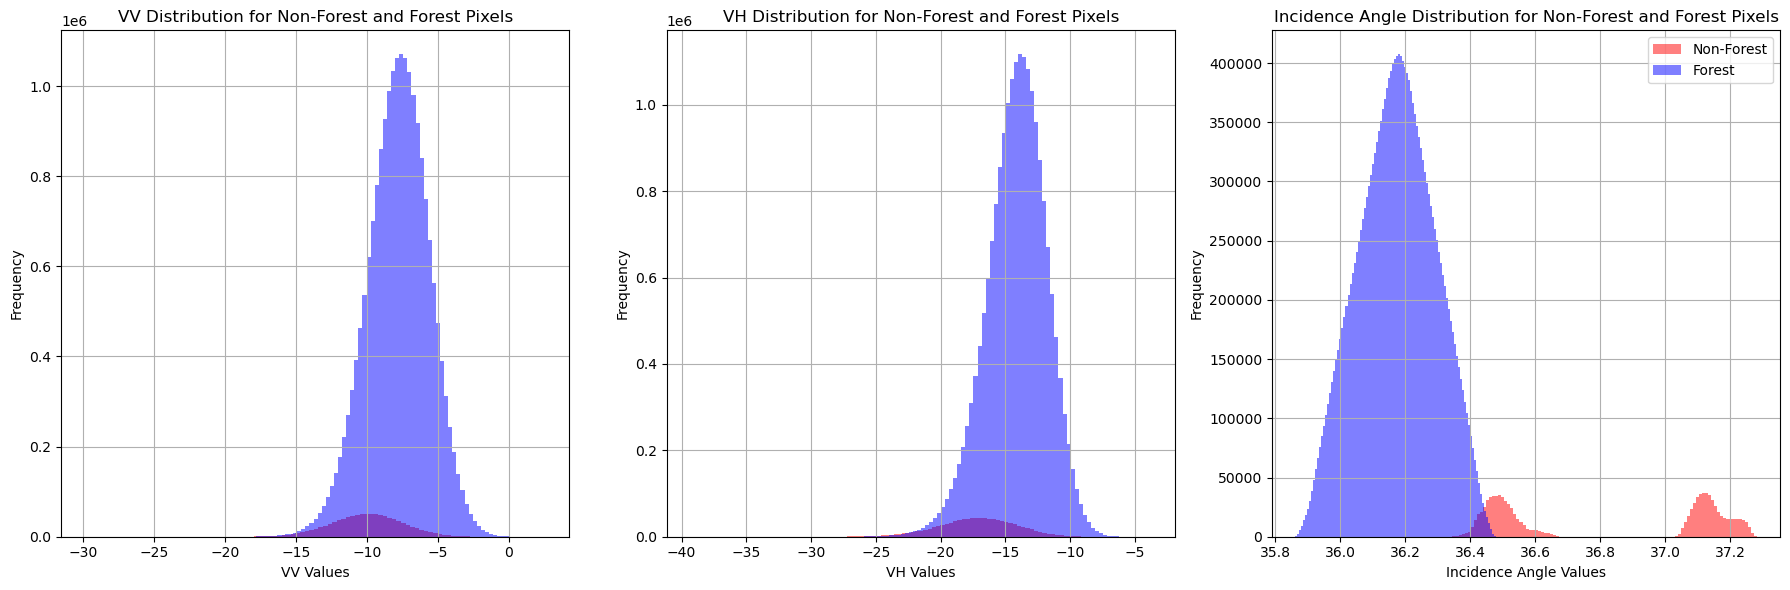

In [8]:
# Function to gather band values
def gather_band_values(data, band_index):
    all_band_values = []
 
    for tile in data:
        band = tile[band_index, :, :]
        band = band[~np.isnan(band)]
        all_band_values.extend(band.flatten())

    return all_band_values

# Plot band distributions for non-forest and forest data
def plot_band_distribution(non_forest_data, forest_data):
    bands = ['VV', 'VH', 'Incidence Angle']
    band_indices = [0, 1, 2]

    plt.figure(figsize=(18, 6))

    for i, band_index in enumerate(band_indices):
        non_forest_band_values = gather_band_values(non_forest_data, band_index)
        forest_band_values = gather_band_values(forest_data, band_index)

        plt.subplot(1, 3, i + 1)
        plt.hist(non_forest_band_values, bins=100, color='red', alpha=0.5, label='Non-Forest')
        plt.hist(forest_band_values, bins=100, color='blue', alpha=0.5, label='Forest')

        plt.title(f'{bands[band_index]} Distribution for Non-Forest and Forest Pixels')
        plt.xlabel(f'{bands[band_index]} Values')
        plt.ylabel('Frequency')
        plt.grid(True)
        if i == 2:  # Only add the legend to the last subplot to avoid repetition
            plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming non_forest_data and forest_data are already loaded and available
plot_band_distribution(non_forest_data, forest_data)


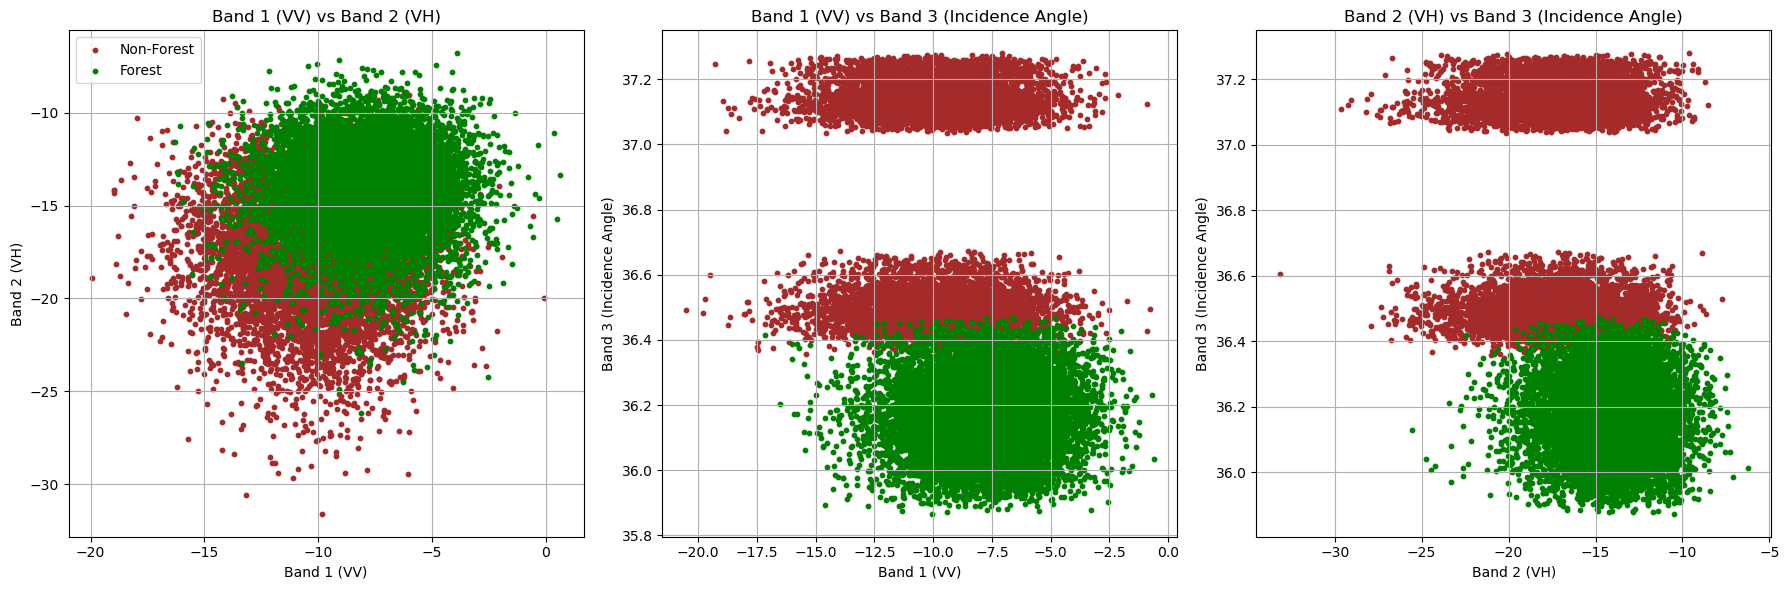

In [29]:
# Function to gather band values and shuffle them
def gather_and_shuffle_band_values(data, band_index, num_samples=1000):
    all_band_values = []

    for tile in data:
        band = tile[band_index, :, :]
        band = band[~np.isnan(band)]
        all_band_values.extend(band.flatten())

    # Shuffle and select a subset of the band values
    random.shuffle(all_band_values)
    return all_band_values[:num_samples]

# Scatter plot for each band combination with shuffled pixels
def plot_band_combinations(non_forest_data, forest_data, num_samples=1000):
    # Band combinations: (0, 1), (0, 2), (1, 2)
    band_pairs = [(0, 1), (0, 2), (1, 2)]
    band_names = ['Band 1 (VV)', 'Band 2 (VH)', 'Band 3 (Incidence Angle)']

    plt.figure(figsize=(18, 6))

    for i, (band_x, band_y) in enumerate(band_pairs):
        # Extract and shuffle band values for non-forest
        non_forest_band_x_values = gather_and_shuffle_band_values(non_forest_data, band_x, num_samples)
        non_forest_band_y_values = gather_and_shuffle_band_values(non_forest_data, band_y, num_samples)

        # Extract and shuffle band values for forest
        forest_band_x_values = gather_and_shuffle_band_values(forest_data, band_x, num_samples)
        forest_band_y_values = gather_and_shuffle_band_values(forest_data, band_y, num_samples)

        plt.subplot(1, 3, i + 1)

        # Scatter plot for non-forest in brown
        plt.scatter(non_forest_band_x_values, non_forest_band_y_values, color='brown', s=10, label='Non-Forest')

        # Scatter plot for forest in green
        plt.scatter(forest_band_x_values, forest_band_y_values, color='green', s=10, label='Forest')

        plt.title(f"{band_names[band_x]} vs {band_names[band_y]}")
        plt.xlabel(band_names[band_x])
        plt.ylabel(band_names[band_y])
        plt.grid(True)

        if i == 0:  # Add legend only to the first plot
            plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the scatter plots for all band combinations
plot_band_combinations(non_forest_data, forest_data, num_samples=10000)


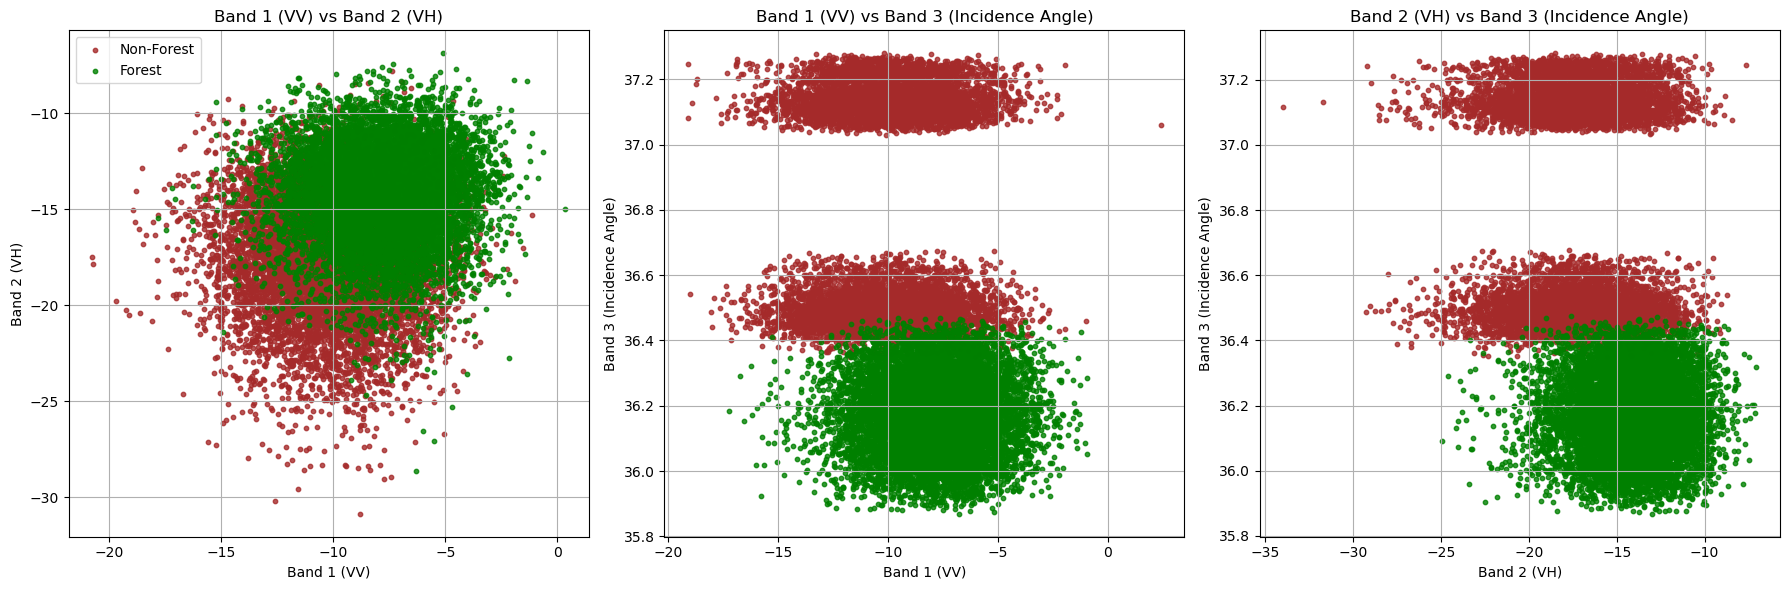

In [36]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Function to gather band values and shuffle them
def gather_and_shuffle_band_values(data, band_index, num_samples=1000):
    all_band_values = []

    for tile in data:
        band = tile[band_index, :, :]
        band = band[~np.isnan(band)]
        all_band_values.extend(band.flatten())

    # Shuffle and select a subset of the band values
    random.shuffle(all_band_values)
    return all_band_values[:num_samples]

# Scatter plot for each band combination with shuffled pixels and transparency
def plot_band_combinations(non_forest_data, forest_data, num_samples=1000, alpha=0.5):
    # Band combinations: (0, 1), (0, 2), (1, 2)
    band_pairs = [(0, 1), (0, 2), (1, 2)]
    band_names = ['Band 1 (VV)', 'Band 2 (VH)', 'Band 3 (Incidence Angle)']

    plt.figure(figsize=(18, 6))

    for i, (band_x, band_y) in enumerate(band_pairs):
        # Extract and shuffle band values for non-forest
        non_forest_band_x_values = gather_and_shuffle_band_values(non_forest_data, band_x, num_samples)
        non_forest_band_y_values = gather_and_shuffle_band_values(non_forest_data, band_y, num_samples)

        # Extract and shuffle band values for forest
        forest_band_x_values = gather_and_shuffle_band_values(forest_data, band_x, num_samples)
        forest_band_y_values = gather_and_shuffle_band_values(forest_data, band_y, num_samples)

        plt.subplot(1, 3, i + 1)

        # Scatter plot for non-forest in brown with transparency
        plt.scatter(non_forest_band_x_values, non_forest_band_y_values, color='brown', s=10, alpha=alpha, label='Non-Forest')

        # Scatter plot for forest in green with transparency
        plt.scatter(forest_band_x_values, forest_band_y_values, color='green', s=10, alpha=alpha, label='Forest')

        plt.title(f"{band_names[band_x]} vs {band_names[band_y]}")
        plt.xlabel(band_names[band_x])
        plt.ylabel(band_names[band_y])
        plt.grid(True)

        if i == 0:  # Add legend only to the first plot
            plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the scatter plots for all band combinations with transparency
plot_band_combinations(non_forest_data, forest_data, num_samples=10000, alpha=0.8)


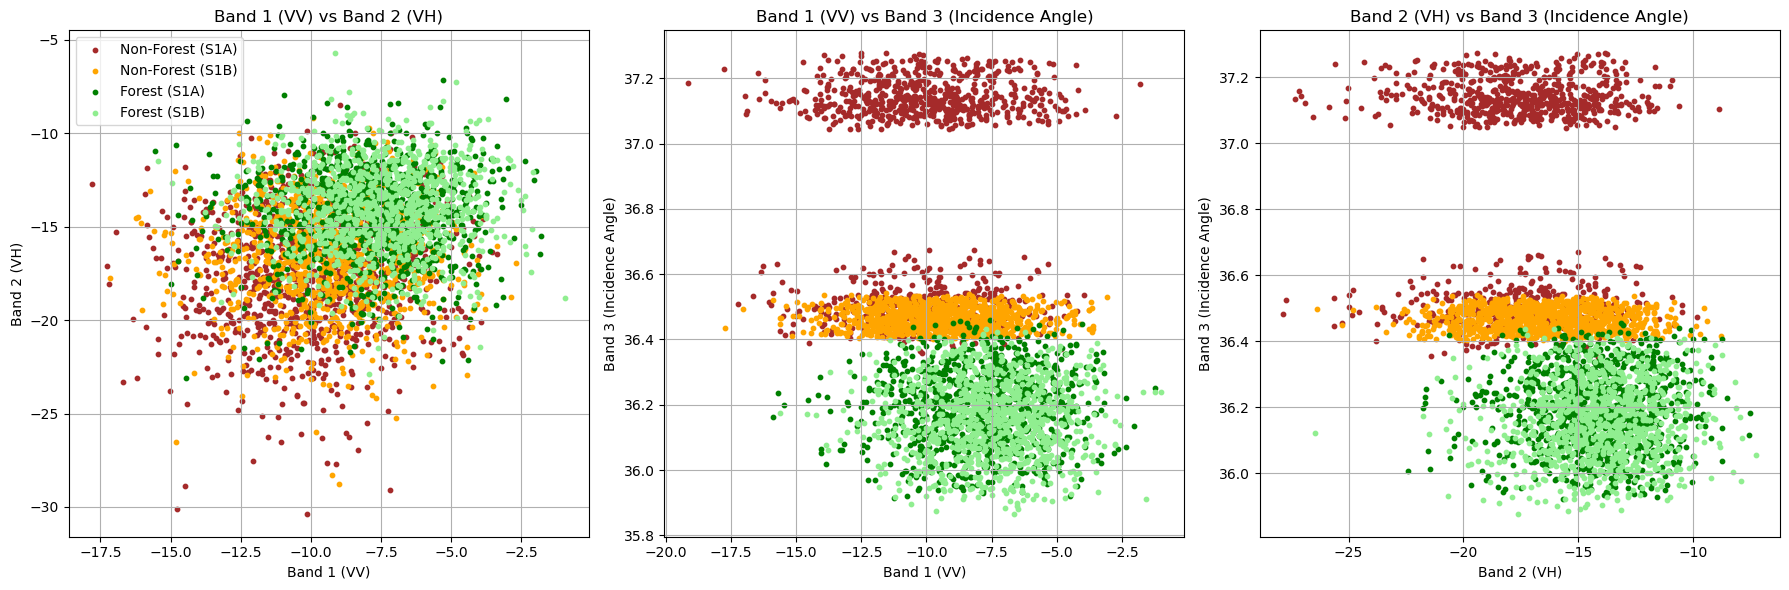

In [33]:
import random

# Function to load data and filter by prefix
def load_and_filter_data_by_prefix(directory, prefix):
    """
    Load TIFF files from a directory and filter them by prefix.
    """
    tif_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.tif') and f.startswith(prefix)]
    bands_list = []
    
    for file_path in tif_files:
        with rasterio.open(file_path) as src:
            bands = src.read()  # shape (3, h, w)
            bands_list.append(bands)
    
    return bands_list

# Load data for each group
non_forest_data_s1a = load_and_filter_data_by_prefix(non_forest_dir, 'S1A')
non_forest_data_s1b = load_and_filter_data_by_prefix(non_forest_dir, 'S1B')
forest_data_s1a = load_and_filter_data_by_prefix(forest_dir, 'S1A')
forest_data_s1b = load_and_filter_data_by_prefix(forest_dir, 'S1B')

# Function to gather band values and shuffle them
def gather_and_shuffle_band_values(data, band_index, num_samples=1000):
    all_band_values = []

    for tile in data:
        band = tile[band_index, :, :]
        band = band[~np.isnan(band)]
        all_band_values.extend(band.flatten())

    # Shuffle and select a subset of the band values
    random.shuffle(all_band_values)
    return all_band_values[:num_samples]

# Scatter plot for each band combination with shuffled pixels from 4 groups
def plot_band_combinations_by_groups(non_forest_data_s1a, non_forest_data_s1b, forest_data_s1a, forest_data_s1b, num_samples=1000):
    # Band combinations: (0, 1), (0, 2), (1, 2)
    band_pairs = [(0, 1), (0, 2), (1, 2)]
    band_names = ['Band 1 (VV)', 'Band 2 (VH)', 'Band 3 (Incidence Angle)']

    plt.figure(figsize=(18, 6))

    for i, (band_x, band_y) in enumerate(band_pairs):
        plt.subplot(1, 3, i + 1)

        # Non-Forest S1A
        non_forest_s1a_band_x_values = gather_and_shuffle_band_values(non_forest_data_s1a, band_x, num_samples)
        non_forest_s1a_band_y_values = gather_and_shuffle_band_values(non_forest_data_s1a, band_y, num_samples)
        plt.scatter(non_forest_s1a_band_x_values, non_forest_s1a_band_y_values, color='brown', s=10, label='Non-Forest (S1A)')

        # Non-Forest S1B
        non_forest_s1b_band_x_values = gather_and_shuffle_band_values(non_forest_data_s1b, band_x, num_samples)
        non_forest_s1b_band_y_values = gather_and_shuffle_band_values(non_forest_data_s1b, band_y, num_samples)
        plt.scatter(non_forest_s1b_band_x_values, non_forest_s1b_band_y_values, color='orange', s=10, label='Non-Forest (S1B)')

        # Forest S1A
        forest_s1a_band_x_values = gather_and_shuffle_band_values(forest_data_s1a, band_x, num_samples)
        forest_s1a_band_y_values = gather_and_shuffle_band_values(forest_data_s1a, band_y, num_samples)
        plt.scatter(forest_s1a_band_x_values, forest_s1a_band_y_values, color='green', s=10, label='Forest (S1A)')

        # Forest S1B
        forest_s1b_band_x_values = gather_and_shuffle_band_values(forest_data_s1b, band_x, num_samples)
        forest_s1b_band_y_values = gather_and_shuffle_band_values(forest_data_s1b, band_y, num_samples)
        plt.scatter(forest_s1b_band_x_values, forest_s1b_band_y_values, color='lightgreen', s=10, label='Forest (S1B)')

        plt.title(f"{band_names[band_x]} vs {band_names[band_y]}")
        plt.xlabel(band_names[band_x])
        plt.ylabel(band_names[band_y])
        plt.grid(True)

        if i == 0:  # Add legend only to the first plot
            plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the scatter plots for all band combinations by groups
plot_band_combinations_by_groups(non_forest_data_s1a, non_forest_data_s1b, forest_data_s1a, forest_data_s1b, num_samples=1000)


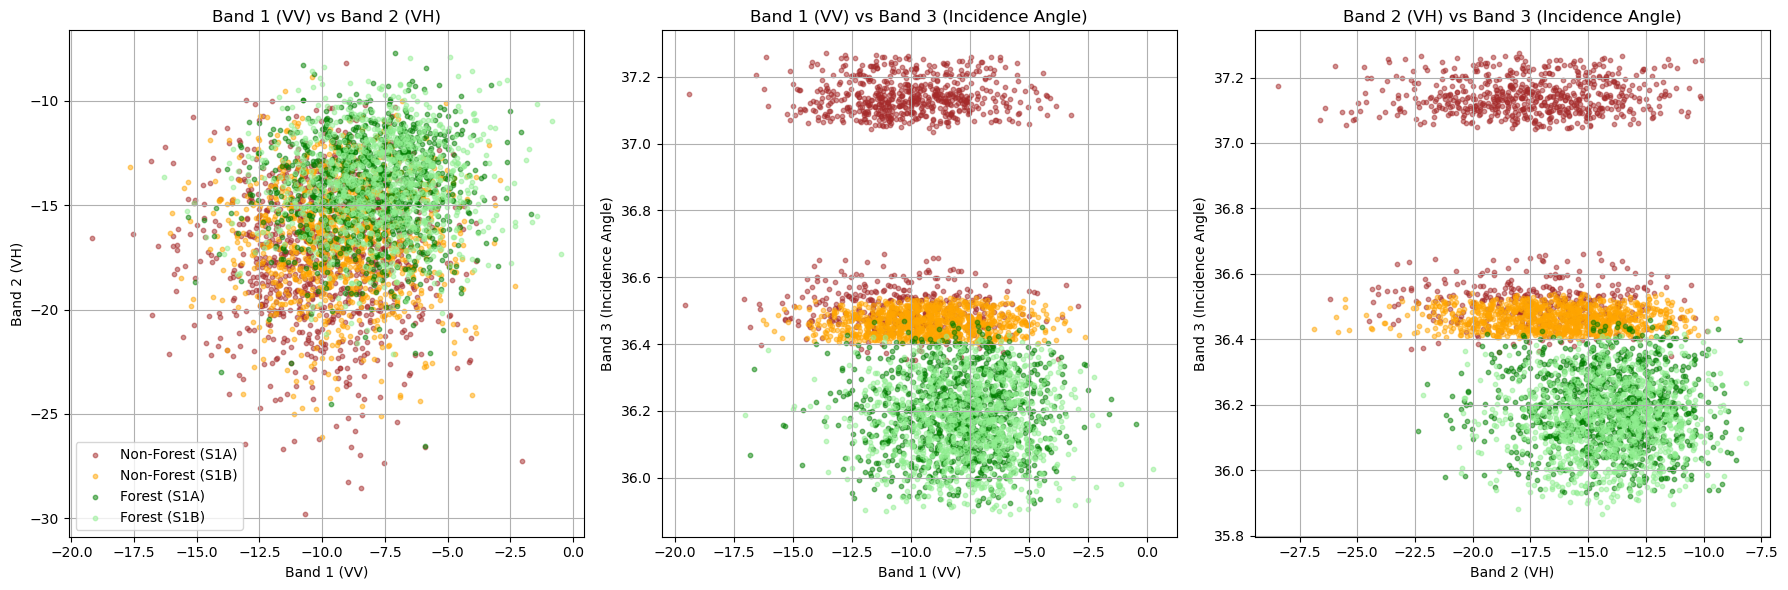

In [37]:
import os
import random
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# Function to load data and filter by prefix
def load_and_filter_data_by_prefix(directory, prefix):
    """
    Load TIFF files from a directory and filter them by prefix.
    """
    tif_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.tif') and f.startswith(prefix)]
    bands_list = []
    
    for file_path in tif_files:
        with rasterio.open(file_path) as src:
            bands = src.read()  # shape (3, h, w)
            bands_list.append(bands)
    
    return bands_list

# Load data for each group
non_forest_data_s1a = load_and_filter_data_by_prefix(non_forest_dir, 'S1A')
non_forest_data_s1b = load_and_filter_data_by_prefix(non_forest_dir, 'S1B')
forest_data_s1a = load_and_filter_data_by_prefix(forest_dir, 'S1A')
forest_data_s1b = load_and_filter_data_by_prefix(forest_dir, 'S1B')

# Function to gather band values and shuffle them
def gather_and_shuffle_band_values(data, band_index, num_samples=1000):
    all_band_values = []

    for tile in data:
        band = tile[band_index, :, :]
        band = band[~np.isnan(band)]
        all_band_values.extend(band.flatten())

    # Shuffle and select a subset of the band values
    random.shuffle(all_band_values)
    return all_band_values[:num_samples]

# Scatter plot for each band combination with shuffled pixels from 4 groups
def plot_band_combinations_by_groups(non_forest_data_s1a, non_forest_data_s1b, forest_data_s1a, forest_data_s1b, num_samples=1000, alpha=0.5):
    # Band combinations: (0, 1), (0, 2), (1, 2)
    band_pairs = [(0, 1), (0, 2), (1, 2)]
    band_names = ['Band 1 (VV)', 'Band 2 (VH)', 'Band 3 (Incidence Angle)']

    plt.figure(figsize=(18, 6))

    for i, (band_x, band_y) in enumerate(band_pairs):
        plt.subplot(1, 3, i + 1)

        # Non-Forest S1A
        non_forest_s1a_band_x_values = gather_and_shuffle_band_values(non_forest_data_s1a, band_x, num_samples)
        non_forest_s1a_band_y_values = gather_and_shuffle_band_values(non_forest_data_s1a, band_y, num_samples)
        plt.scatter(non_forest_s1a_band_x_values, non_forest_s1a_band_y_values, color='brown', s=10, alpha=alpha, label='Non-Forest (S1A)')

        # Non-Forest S1B
        non_forest_s1b_band_x_values = gather_and_shuffle_band_values(non_forest_data_s1b, band_x, num_samples)
        non_forest_s1b_band_y_values = gather_and_shuffle_band_values(non_forest_data_s1b, band_y, num_samples)
        plt.scatter(non_forest_s1b_band_x_values, non_forest_s1b_band_y_values, color='orange', s=10, alpha=alpha, label='Non-Forest (S1B)')

        # Forest S1A
        forest_s1a_band_x_values = gather_and_shuffle_band_values(forest_data_s1a, band_x, num_samples)
        forest_s1a_band_y_values = gather_and_shuffle_band_values(forest_data_s1a, band_y, num_samples)
        plt.scatter(forest_s1a_band_x_values, forest_s1a_band_y_values, color='green', s=10, alpha=alpha, label='Forest (S1A)')

        # Forest S1B
        forest_s1b_band_x_values = gather_and_shuffle_band_values(forest_data_s1b, band_x, num_samples)
        forest_s1b_band_y_values = gather_and_shuffle_band_values(forest_data_s1b, band_y, num_samples)
        plt.scatter(forest_s1b_band_x_values, forest_s1b_band_y_values, color='lightgreen', s=10, alpha=alpha, label='Forest (S1B)')

        plt.title(f"{band_names[band_x]} vs {band_names[band_y]}")
        plt.xlabel(band_names[band_x])
        plt.ylabel(band_names[band_y])
        plt.grid(True)

        if i == 0:  # Add legend only to the first plot
            plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the scatter plots for all band combinations by groups with transparency
plot_band_combinations_by_groups(non_forest_data_s1a, non_forest_data_s1b, forest_data_s1a, forest_data_s1b, num_samples=1000, alpha=0.5)
